In this project we count the number and analyze users that churned from using Sparkify, meaning we extract more information on the users that stopped using Sparkify. And make some predictions

Connecting to google drive, To access the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installing PySpark and import essential pakages

In [ ]:
!pip install pyspark
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

import datetime
import time

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 44 kB/s 
     |████████████████████████████████| 199 kB 61.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845513 sha256=7a028fa38a36259a5312994aa23f3e3be35ad30d8211747d839b7a5ea0b876f5
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


Creating a Spark Session

In [ ]:
spark = SparkSession \
    .builder \
    .appName("Sparkify Capstone Project") \
    .getOrCreate()

Reading Dataset

In [ ]:
df = spark.read.json("/content/drive/MyDrive/medium-sparkify-event-data.json")

Print Schema of the dataset and the dataset, also checking if the dataset is properly loaded

In [ ]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [ ]:
df.show()

+--------------------+----------+---------+------+-------------+---------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|      auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+----------+---------+------+-------------+---------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|       Martin Orford| Logged In|   Joseph|     M|           20|  Morales|597.55057| free|  Corpus Christi, TX|   PUT|       NextSong|1532063507000|      292|       Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
|   John Brown's Body| Logged In|   Sawyer|     M|           74|   Larson|380.21179|

In [ ]:
df.count()

543705

Conditioning of the dataset by Dropping Duplicates

In [ ]:
df.select("gender").dropDuplicates().sort("gender").show()

+------+
|gender|
+------+
|  null|
|     F|
|     M|
+------+



In [ ]:
df.select("auth").dropDuplicates().sort("auth").show()

+----------+
|      auth|
+----------+
| Cancelled|
|     Guest|
| Logged In|
|Logged Out|
+----------+



In [ ]:
df.select("userAgent").dropDuplicates().sort("userAgent").show()

+--------------------+
|           userAgent|
+--------------------+
|                null|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
+--------------------+
only showing top 20 rows



In [ ]:
df.select("registration").dropDuplicates().sort("registration").show()

+-------------+
| registration|
+-------------+
|         null|
|1509854193000|
|1519397713000|
|1521380675000|
|1522076012000|
|1522793334000|
|1523464964000|
|1523721066000|
|1523777521000|
|1526739206000|
|1526838391000|
|1527013865000|
|1527341164000|
|1527476190000|
|1528403713000|
|1528560242000|
|1528772084000|
|1528780738000|
|1528833373000|
|1528996419000|
+-------------+
only showing top 20 rows



In [ ]:
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [ ]:
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



Before duplicate values were dropped, the total rows were : 543705;
Total rows after dropping: 528005

In [ ]:
df_before = df.count()
df_before
df = df.filter(df["userId"] != "")
df.count()
print("rows dropped = " + str(df_before - df.count()))

rows dropped = 15700


In [ ]:
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [ ]:
print("count of users who churned : " + str(df.select(["userId", "page"]).where(df["page"] == "Cancellation Confirmation").count()))

count of users who churned : 99


In [ ]:
user_count = df.select(["userId", "page"]).where(df["page"] == "Cancellation Confirmation").count()

df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").show(user_count)

+------+--------------------+
|userId|                page|
+------+--------------------+
|   208|Cancellation Conf...|
|   231|Cancellation Conf...|
|   236|Cancellation Conf...|
|   156|Cancellation Conf...|
|   271|Cancellation Conf...|
|   200|Cancellation Conf...|
|   130|Cancellation Conf...|
|   123|Cancellation Conf...|
|    54|Cancellation Conf...|
|    39|Cancellation Conf...|
|   154|Cancellation Conf...|
|   132|Cancellation Conf...|
|    10|Cancellation Conf...|
|   296|Cancellation Conf...|
|   187|Cancellation Conf...|
|    51|Cancellation Conf...|
|    13|Cancellation Conf...|
|    32|Cancellation Conf...|
|    28|Cancellation Conf...|
|   198|Cancellation Conf...|
|   196|Cancellation Conf...|
|   172|Cancellation Conf...|
|   189|Cancellation Conf...|
|   234|Cancellation Conf...|
|    16|Cancellation Conf...|
|   214|Cancellation Conf...|
|   246|Cancellation Conf...|
|    88|Cancellation Conf...|
|    45|Cancellation Conf...|
|    61|Cancellation Conf...|
|   124|Ca

In [ ]:
churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churn', churn_event('page'))

In [ ]:
windowval = Window.partitionBy('userId')
df = df.withColumn('churn', max('churn').over(windowval))
df.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   99|
|    0|  349|
+-----+-----+



In [ ]:
df.select(["page","churn"]).where(df.page == "Cancellation Confirmation").show(5)

+--------------------+-----+
|                page|churn|
+--------------------+-----+
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
|Cancellation Conf...|    1|
+--------------------+-----+
only showing top 5 rows



In [ ]:
df.select(["page","churn"]).where(df.page != "Cancellation Confirmation").show(5)

+--------+-----+
|    page|churn|
+--------+-----+
|NextSong|    1|
|    Home|    1|
|NextSong|    1|
|NextSong|    1|
|NextSong|    1|
+--------+-----+
only showing top 5 rows



In [ ]:
df_pandas = df.toPandas()
df_pandas.head(3)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,None,Logged In,Colin,M,0,Larson,NaN,free,"Dallas-Fort Worth-Arlington, TX",GET,Home,1537982255000,497,None,200,1538352241000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,100,0
1,Amy Winehouse,Logged In,Colin,M,1,Larson,201.50812,free,"Dallas-Fort Worth-Arlington, TX",PUT,NextSong,1537982255000,497,Teach Me Tonight,200,1538352259000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,100,0
2,The Strokes,Logged In,Colin,M,2,Larson,187.34975,free,"Dallas-Fort Worth-Arlington, TX",PUT,NextSong,1537982255000,497,You Only Live Once,200,1538352460000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,100,0


In [ ]:
# churn status by gender
df.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    1|     F|   45|
|    0|     M|  196|
|    1|     M|   54|
|    0|     F|  153|
+-----+------+-----+



In [ ]:
# churn status by paid lever
df.dropDuplicates(['userId', 'level']).groupby(['churn', 'level']).count().show()

+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|    0| free|  288|
|    0| paid|  246|
|    1| paid|   75|
|    1| free|   82|
+-----+-----+-----+



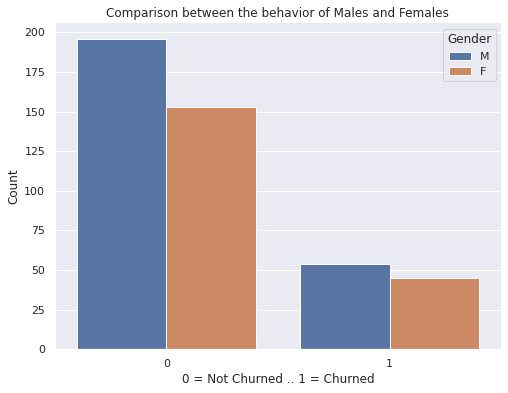

In [ ]:
# Comparison between the behavior of Males and Females
barplot_gender_churn = df.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()

plt.figure(figsize = [8,6])
ax = sns.barplot(x='churn', y='count', hue='gender', data=barplot_gender_churn)

plt.xlabel('0 = Not Churned .. 1 = Churned')
plt.ylabel('Count')
plt.legend(title='Gender', loc='best')
plt.title('Comparison between the behavior of Males and Females')

sns.despine(ax=ax);

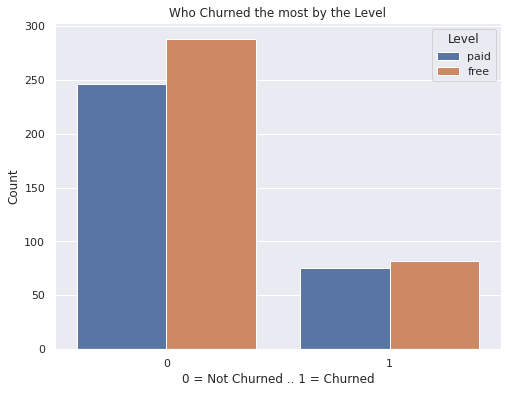

In [ ]:
level_barplot = df.select(['userId', 'churn', 'level']).dropDuplicates().groupBy('level','churn').count().toPandas()

plt.figure(figsize = [8,6])
ax = sns.barplot(data = level_barplot, x = 'churn', y='count', hue = 'level')
plt.ylabel('Count')
plt.xlabel('0 = Not Churned .. 1 = Churned')
plt.title('Who Churned the most by the Level')

ax.legend(title = 'Level', loc='best')

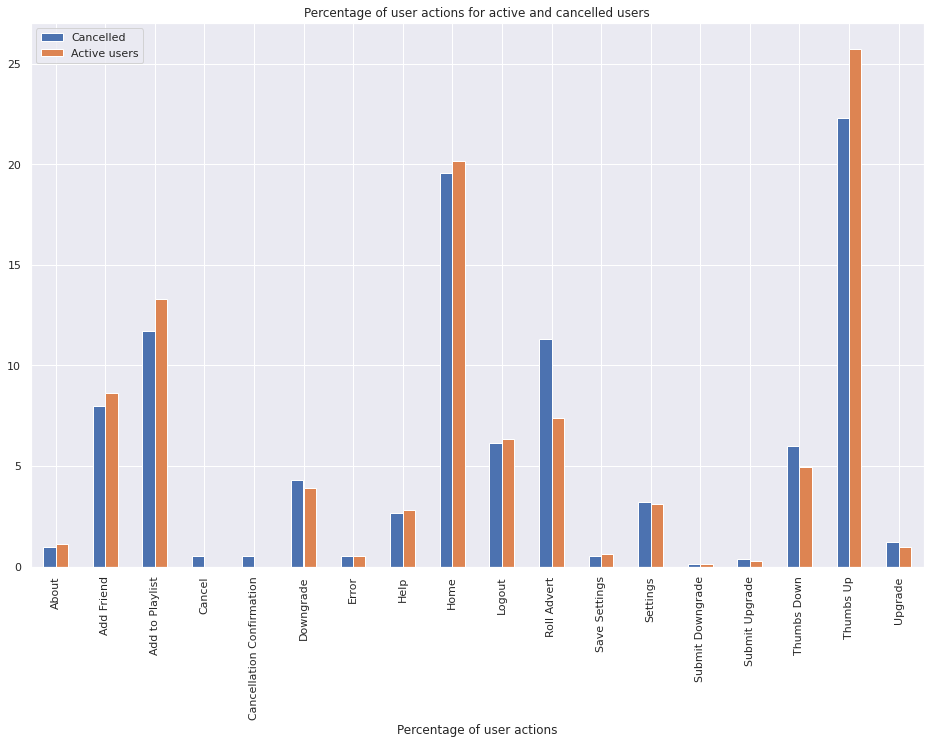

In [ ]:
# Getting the data needed, next song dropped because it's affecting the data visualization 
users_1 = df_pandas[df_pandas.churn == 1].groupby(['page'])['userId'].count().drop('NextSong')
users_0 = df_pandas[df_pandas.churn == 0].groupby(['page'])['userId'].count().drop('NextSong')

# Calculating the percentage
users_1 = users_1 /users_1.sum()*100
users_0 = users_0 /users_0.sum()*100

# Creating a dataframe containing both cancelled and active users
plot_df = pd.DataFrame({'Cancelled': users_1,'Active users':users_0})

# Creating the barplot
ax = plot_df.plot(kind='bar', figsize=(16,10));
ax.set_xlabel('Percentage of user actions')
ax.set_title('Percentage of user actions for active and cancelled users')
ax.legend(loc='best')

In [ ]:
# only take userId, gender and drop duplicates
gender_changed_m0_f1 = df.select(['userId', 'gender']).dropDuplicates()
# update the value of gender column
gender_changed_m0_f1 = gender_changed_m0_f1.withColumn('gender', when(col('gender') == 'M', 0).otherwise(1))
gender_changed_m0_f1.describe().show()

+-------+------------------+------------------+
|summary|            userId|            gender|
+-------+------------------+------------------+
|  count|               448|               448|
|   mean| 67520.34821428571|0.4419642857142857|
| stddev|105964.58428485185|0.4971756279079039|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [ ]:
# only take userId, level, ts and drop duplicates 
# To perform an operation on a group we need to partition the data
df_level = df.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')
w = Window.partitionBy("userId").orderBy(desc("ts"))
# the rank of rows within a window partition, with gaps.
df_level = df_level.withColumn("rank", dense_rank().over(w))
df_level.show(10)

+------+-----+-------------+----+
|userId|level|           ts|rank|
+------+-----+-------------+----+
|    10| paid|1539055364000|   1|
|    10| paid|1539055349000|   2|
|    10| paid|1539055348000|   3|
|    10| paid|1539055323000|   4|
|    10| paid|1539055047000|   5|
|    10| paid|1539054916000|   6|
|    10| paid|1539054915000|   7|
|    10| paid|1539054663000|   8|
|    10| paid|1539054454000|   9|
|    10| paid|1539054219000|  10|
+------+-----+-------------+----+
only showing top 10 rows



In [ ]:
# Filters rows using the given condition
df_level2 = df_level.filter(df_level.rank == 1).drop(df_level.rank)
# Dropping ts becouse there is no need for it
df_level2 = df_level2.drop('ts')
# update the value of level column
df_level2 = df_level2.withColumn('level', when(col('level') == 'free', 0).otherwise(1))
df_level2.describe().show()

+-------+------------------+-------------------+
|summary|            userId|              level|
+-------+------------------+-------------------+
|  count|               448|                448|
|   mean| 67520.34821428571| 0.6160714285714286|
| stddev|105964.58428485185|0.48688455263386654|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [ ]:
# Filters rows using the given condition
df_level2 = df_level.filter(df_level.rank == 1).drop(df_level.rank)
# Dropping ts becouse there is no need for it
df_level2 = df_level2.drop('ts')
# update the value of level column
df_level2 = df_level2.withColumn('level', when(col('level') == 'free', 0).otherwise(1))
df_level2.describe().show()

+-------+------------------+-------------------+
|summary|            userId|              level|
+-------+------------------+-------------------+
|  count|               448|                448|
|   mean| 67520.34821428571| 0.6160714285714286|
| stddev|105964.58428485185|0.48688455263386654|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [ ]:
# only take userId and page
thumbdown_feature = df.select(["userId", "page"])
thumbdown_feature = thumbdown_feature.withColumn("Thumbs Down", udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())("page"))
# summing the number of thumbe downs for each user and assign it to column thumbs_down
thumbdown_feature = thumbdown_feature.groupby('userId').sum("Thumbs Down")
thumbdown_feature = thumbdown_feature.withColumnRenamed("sum(Thumbs Down)", "thumbs_down")
thumbdown_feature.describe().show(10)

+-------+------------------+------------------+
|summary|            userId|       thumbs_down|
+-------+------------------+------------------+
|  count|               448|               448|
|   mean| 67520.34821428571|10.962053571428571|
| stddev|105964.58428485185|13.356609011067462|
|    min|                10|                 0|
|    max|                99|                80|
+-------+------------------+------------------+



In [ ]:
# only take userId and page
thumbup_feature = df.select(["userId", "page"])
thumbup_feature = thumbup_feature.withColumn("Thumbs Up", udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())("page"))
# summing the number of thumbe ups for each user and assign it to column thumbs_down
thumbup_feature = thumbup_feature.groupby('userId').sum("Thumbs Up")
thumbup_feature = thumbup_feature.withColumnRenamed("sum(Thumbs Up)", "thumbs_up")
thumbup_feature.describe().show()

+-------+------------------+------------------+
|summary|            userId|         thumbs_up|
+-------+------------------+------------------+
|  count|               448|               448|
|   mean| 67520.34821428571|53.183035714285715|
| stddev|105964.58428485185| 69.65210755898285|
|    min|                10|                 0|
|    max|                99|               506|
+-------+------------------+------------------+



In [ ]:
# only take userId, artist and drop duplicates and count how many time a singel user listened to the same artist
listenedTo_artists = df.select("userId", "artist").dropDuplicates().groupby("userId").count()
listenedTo_artists.show(5)

+------+-----+
|userId|count|
+------+-----+
|   296|  109|
|100010|   95|
|200002|  288|
|   125|   62|
|   124| 1241|
+------+-----+
only showing top 5 rows



In [ ]:
# update the value of count column
listenedTo_artists = listenedTo_artists.withColumnRenamed("count", "number_of_artists_listenedTo")
listenedTo_artists.describe().show()

+-------+------------------+----------------------------+
|summary|            userId|number_of_artists_listenedTo|
+-------+------------------+----------------------------+
|  count|               448|                         448|
|   mean| 67520.34821428571|           659.9799107142857|
| stddev|105964.58428485188|            625.882698051957|
|    min|                10|                           2|
|    max|                99|                        3508|
+-------+------------------+----------------------------+



In [ ]:
# only take userId, churn and drop duplicates, group by userId nnd churn
label = df.select("userId", "churn").dropDuplicates().groupby("userId", "churn").count()
label.count()
label.show(5)

+------+-----+-----+
|userId|churn|count|
+------+-----+-----+
|    10|    1|    1|
|   100|    0|    1|
|100001|    1|    1|
|100002|    0|    1|
|100003|    1|    1|
+------+-----+-----+
only showing top 5 rows



In [ ]:
# dropping count column and renameing churn to label
label = label.drop('count')
label = label.withColumnRenamed("churn", "label")
label.show(10)

+------+-----+
|userId|label|
+------+-----+
|    10|    1|
|   100|    0|
|100001|    1|
|100002|    0|
|100003|    1|
|100004|    1|
|100005|    1|
|100006|    0|
|100007|    0|
|100008|    0|
+------+-----+
only showing top 10 rows



In [ ]:
features_join_df = gender_changed_m0_f1\
                   .join(df_level2, ["userId"])\
                   .join(thumbdown_feature, ["userId"])\
                   .join(thumbup_feature, ["userId"])\
                   .join(listenedTo_artists, ["userId"])\
                   .join(label, ["userId"])\
                   .drop('userID')
features_join_df.show(10)

+------+-----+-----------+---------+----------------------------+-----+
|gender|level|thumbs_down|thumbs_up|number_of_artists_listenedTo|label|
+------+-----+-----------+---------+----------------------------+-----+
|     0|    1|          1|       17|                         307|    1|
|     0|    1|         37|      143|                        1964|    0|
|     1|    0|          1|        5|                          94|    1|
|     1|    0|          2|        8|                         129|    0|
|     1|    1|         10|       16|                         546|    1|
|     1|    0|          2|       15|                         243|    1|
|     0|    0|          1|        2|                          70|    1|
|     1|    0|          3|       14|                         262|    0|
|     1|    0|          6|       40|                         681|    0|
|     1|    1|          5|       19|                         337|    0|
+------+-----+-----------+---------+----------------------------

In [ ]:
# Prints out the schema in the tree format and cehck for data types
features_join_df.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- level: integer (nullable = false)
 |-- thumbs_down: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- number_of_artists_listenedTo: long (nullable = false)
 |-- label: integer (nullable = true)



In [ ]:
# loop to go throu all the columns and casting them to float type 
for i in features_join_df.columns:
    features_join_df = features_join_df.withColumn(i, features_join_df[i].cast('float'))
# Prints out the schema in the tree format and cehck for data types
features_join_df.printSchema()

root
 |-- gender: float (nullable = false)
 |-- level: float (nullable = false)
 |-- thumbs_down: float (nullable = true)
 |-- thumbs_up: float (nullable = true)
 |-- number_of_artists_listenedTo: float (nullable = false)
 |-- label: float (nullable = true)



In [ ]:
# Vector assembler
columns = ["gender", "level", "thumbs_down", "thumbs_up", "number_of_artists_listenedTo"]
v_assembler = VectorAssembler(inputCols=columns, outputCol="v_features")
features_join_df = v_assembler.transform(features_join_df)
features_join_df.show(10)

+------+-----+-----------+---------+----------------------------+-----+--------------------+
|gender|level|thumbs_down|thumbs_up|number_of_artists_listenedTo|label|          v_features|
+------+-----+-----------+---------+----------------------------+-----+--------------------+
|   0.0|  1.0|        1.0|     17.0|                       307.0|  1.0|[0.0,1.0,1.0,17.0...|
|   0.0|  1.0|       37.0|    143.0|                      1964.0|  0.0|[0.0,1.0,37.0,143...|
|   1.0|  0.0|        1.0|      5.0|                        94.0|  1.0|[1.0,0.0,1.0,5.0,...|
|   1.0|  0.0|        2.0|      8.0|                       129.0|  0.0|[1.0,0.0,2.0,8.0,...|
|   1.0|  1.0|       10.0|     16.0|                       546.0|  1.0|[1.0,1.0,10.0,16....|
|   1.0|  0.0|        2.0|     15.0|                       243.0|  1.0|[1.0,0.0,2.0,15.0...|
|   0.0|  0.0|        1.0|      2.0|                        70.0|  1.0|[0.0,0.0,1.0,2.0,...|
|   1.0|  0.0|        3.0|     14.0|                       262.0|  0.0

In [ ]:
# standardize the features
scaler = StandardScaler(inputCol="v_features", outputCol="features", withStd=True)
scalerModel = scaler.fit(features_join_df)
features_join_df = scalerModel.transform(features_join_df)
features_join_df.show(2)

+------+-----+-----------+---------+----------------------------+-----+--------------------+--------------------+
|gender|level|thumbs_down|thumbs_up|number_of_artists_listenedTo|label|          v_features|            features|
+------+-----+-----------+---------+----------------------------+-----+--------------------+--------------------+
|   0.0|  1.0|        1.0|     17.0|                       307.0|  1.0|[0.0,1.0,1.0,17.0...|[0.0,2.0538749783...|
|   0.0|  1.0|       37.0|    143.0|                      1964.0|  0.0|[0.0,1.0,37.0,143...|[0.0,2.0538749783...|
+------+-----+-----------+---------+----------------------------+-----+--------------------+--------------------+
only showing top 2 rows



In [ ]:
# train test split
train, test, validation= features_join_df.randomSplit([0.6, 0.2, 0.2], seed=1385)
train_count = train.count()
train_count

271

In [ ]:
test_count = test.count()
test_count

99

In [ ]:
validation_count = validation.count()
validation_count

78

In [ ]:
# printing the sum of all splits - must be 225 
print(train_count + test_count + validation_count)

448


In [ ]:
# create column called prediction and assign an intial value for all users 
f1_all_1 = test.withColumn('prediction', lit(1.0))
f1_all_0 = test.withColumn('prediction', lit(0.0))

In [ ]:
f1_all_1.show(1)

+------+-----+-----------+---------+----------------------------+-----+--------------------+--------------------+----------+
|gender|level|thumbs_down|thumbs_up|number_of_artists_listenedTo|label|          v_features|            features|prediction|
+------+-----+-----------+---------+----------------------------+-----+--------------------+--------------------+----------+
|   0.0|  0.0|        0.0|      1.0|                        49.0|  0.0|(5,[3,4],[1.0,49.0])|(5,[3,4],[0.01435...|       1.0|
+------+-----+-----------+---------+----------------------------+-----+--------------------+--------------------+----------+
only showing top 1 row



In [ ]:
f1_all_0.show(1)

+------+-----+-----------+---------+----------------------------+-----+--------------------+--------------------+----------+
|gender|level|thumbs_down|thumbs_up|number_of_artists_listenedTo|label|          v_features|            features|prediction|
+------+-----+-----------+---------+----------------------------+-----+--------------------+--------------------+----------+
|   0.0|  0.0|        0.0|      1.0|                        49.0|  0.0|(5,[3,4],[1.0,49.0])|(5,[3,4],[0.01435...|       0.0|
+------+-----+-----------+---------+----------------------------+-----+--------------------+--------------------+----------+
only showing top 1 row



In [ ]:
# evaluate
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

accuracy = evaluator.evaluate(f1_all_1, {evaluator.metricName: "accuracy"})
f1_Score = evaluator.evaluate(f1_all_1, {evaluator.metricName: "f1"})

In [ ]:
print("Accuracy for all users 1 : " + str(accuracy * 100) + " %")
print("f1_Score for all users 1 : " + str(f1_Score))

Accuracy for all users 1 : 26.262626262626267 %
f1_Score for all users 1 : 0.10925252525252528


In [ ]:
# evaluate
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

accuracy = evaluator.evaluate(f1_all_0, {evaluator.metricName: "accuracy"})
f1_Score = evaluator.evaluate(f1_all_0, {evaluator.metricName: "f1"})

In [ ]:
print("Accuracy for all users 0 : " + str(accuracy * 100) + " %")
print("f1_Score for all users 0 : " + str(f1_Score))

Accuracy for all users 0 : 73.73737373737373 %
f1_Score for all users 0 : 0.625910265445149


In [ ]:
# creating the classifier
gradient_boosted_tree = GBTClassifier(maxIter = 10, seed = 1385)

# create evaluator
gbt_f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build param grid using ParamGridBuilder
grid = ParamGridBuilder().build()

# numFolds is 3 to speed up the process
gbtCrossValue = CrossValidator(estimator = gradient_boosted_tree, 
                              estimatorParamMaps = grid,
                              evaluator = gbt_f1_evaluator,
                              numFolds = 3)
# start time
start = time.time()

#  fit the models on train dataset
cvModel_gbt = gbtCrossValue.fit(train)

# end time
end = time.time()

time_take = end - start
if time_take >= 60:
    print("Time taken to process training : " + str(time_take / 60) + " Minutes.")
else:
    print("Time taken to process training : " + str(time_take) + " Seconds.")

cvModel_gbt.avgMetrics
gbt_results = cvModel_gbt.transform(validation)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

print('-----------------------------------')
print('GBT Train Metrics:')

accuracy = evaluator.evaluate(gbt_results, {evaluator.metricName: "accuracy"})
print("Accuracy : " + str(accuracy * 100) + " %")

f1_Score = evaluator.evaluate(gbt_results, {evaluator.metricName: "f1"})
print("f1_Score : " + str(f1_Score))

Time taken to process training : 11.849255379041036 Minutes.
-----------------------------------
GBT Train Metrics:
Accuracy : 76.92307692307693 %
f1_Score : 0.7534965034965034


In [ ]:
# creating the classifier
random_forest = RandomForestClassifier()

# create evaluator
rf_f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build param grid using ParamGridBuilder
grid = ParamGridBuilder().build()

# numFolds is 3 to speed up the process
rfCrossValue = CrossValidator(estimator = random_forest, 
                              estimatorParamMaps = grid,
                              evaluator = rf_f1_evaluator,
                              numFolds = 3)
# start time
start = time.time()

#  fit the models on train dataset
cvModel_rf = rfCrossValue.fit(train)

# end time
end = time.time()

time_take = end - start
if time_take >= 60:
    print("Time taken to process training : " + str(time_take / 60) + " Minutes.")
else:
    print("Time taken to process training : " + str(time_take) + " Seconds.")

cvModel_rf.avgMetrics
rf_results = cvModel_rf.transform(validation)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

print('-----------------------------------')
print('RF Train Metrics:')

accuracy = evaluator.evaluate(rf_results, {evaluator.metricName: "accuracy"})
print("Accuracy : " + str(accuracy * 100) + " %")

f1_Score = evaluator.evaluate(rf_results, {evaluator.metricName: "f1"})
print("f1_Score : " + str(f1_Score))

Time taken to process training : 8.880055650075276 Minutes.
-----------------------------------
RF Train Metrics:
Accuracy : 75.64102564102564 %
f1_Score : 0.7067190716825753


In [ ]:
# creating the classifier
logistic_regression = LogisticRegression(maxIter=10)

# create evaluator
lr_f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build param grid using ParamGridBuilder
grid = ParamGridBuilder().build()

# numFolds is 3 to speed up the process
lrCrossValue = CrossValidator(estimator = logistic_regression, 
                              estimatorParamMaps = grid,
                              evaluator = lr_f1_evaluator,
                              numFolds = 3)
# start time
start = time.time()

#  fit the models on train dataset
cvModel_lr = lrCrossValue.fit(train)

# end time
end = time.time()

time_take = end - start
if time_take >= 60:
    print("Time taken to process training : " + str(time_take / 60) + " Minutes.")
else:
    print("Time taken to process training : " + str(time_take) + " Seconds.")

cvModel_lr.avgMetrics
lr_results = cvModel_lr.transform(validation)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

print('-----------------------------------')
print('LR Train Metrics:')

accuracy = evaluator.evaluate(lr_results, {evaluator.metricName: "accuracy"})
print("Accuracy : " + str(accuracy * 100) + " %")

f1_Score = evaluator.evaluate(lr_results, {evaluator.metricName: "f1"})
print("f1_Score : " + str(f1_Score))

Time taken to process training : 7.800274181365967 Minutes.
-----------------------------------
LR Train Metrics:
Accuracy : 76.92307692307693 %
f1_Score : 0.713489409141583


In [ ]:
# creating the classifier
random_forest = RandomForestClassifier(seed=1385)

# create evaluator
rf_f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build param grid using ParamGridBuilder
# Should be 
    # ParamGridBuilder()
    # .addGrid(random_forest.numTrees,[20, 50, 100])
    # .addGrid(random_forest.maxDepth,[5, 10, 15])
    # .build()
# but for the time is taken we will sticking for the below
grid = ParamGridBuilder() \
    .addGrid(random_forest.numTrees,[20]) \
    .addGrid(random_forest.maxDepth,[5]) \
    .build()

# numFolds is 3 to speed up the process
rfCrossValue = CrossValidator(estimator = random_forest, 
                              estimatorParamMaps = grid,
                              evaluator = rf_f1_evaluator,
                              numFolds = 3)

In [ ]:
start = time.time()
cvModel_rf = rfCrossValue.fit(train)
end = time.time()

time_take = end - start
if time_take >= 60:
    print("Time taken to process training : " + str(time_take / 60) + " Minutes.")
else:
    print("Time taken to process training : " + str(time_take) + " Seconds.")


print('----------------------------------------------')
cvModel_rf.avgMetrics

Time taken to process training : 8.421143956979115 Minutes.
----------------------------------------------


[0.6827208243807319]

In [ ]:
rf_final_results = cvModel_rf.transform(validation)

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

print('RF Test Metrics:')

accuracy = evaluator.evaluate(rf_results, {evaluator.metricName: "accuracy"})
print("Accuracy : " + str(accuracy * 100) + " %")

f1_Score = evaluator.evaluate(rf_results, {evaluator.metricName: "f1"})
print("f1_Score : " + str(f1_Score))

RF Test Metrics:
Accuracy : 75.64102564102564 %
f1_Score : 0.7067190716825753


In [ ]:
best_model = cvModel_rf.bestModel

In [ ]:
print ("Best Number of Trees Parameter: ", best_model._java_obj.getNumTrees())
print ("Best Max Depth Parameter: ", best_model._java_obj.getMaxDepth())

Best Number of Trees Parameter:  20
Best Max Depth Parameter:  5


In [ ]:
importances = best_model.featureImportances

In [ ]:
x_values = list(range(len(importances)))

In [ ]:
feature_list = list(["gender", "level", "thumbs_down", "thumbs_up", "number_of_artists_listenedTo"])

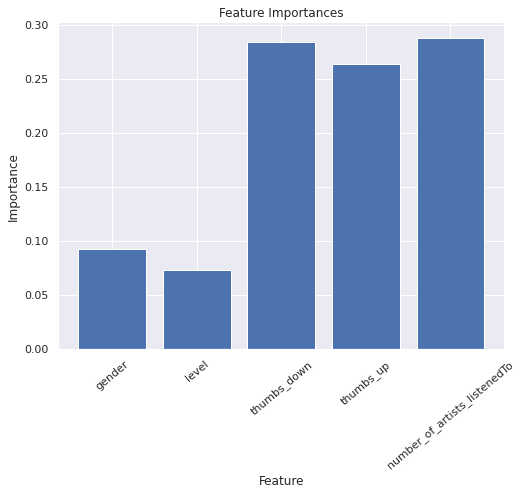

In [ ]:
plt.figure(figsize=[8,6])
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances');